# Fine-Tuning a Large Language Model (LLM) for Spam Detection

This notebook demonstrates how to fine-tune a transformer-based large language model for the binary classification of spam in text messages. 
It covers loading and preparing data, encoding with Hugging Face Transformers, dataset setup, model training, and evaluation.


In [ ]:
import pandas as pd
import torch
import numpy as np
from transformers import  Trainer, TrainingArguments,DistilBertTokenizer,DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,precision_recall_fscore_support


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load and clean the preprocessed spam dataset from CSV
df = pd.read_csv('/Users/user/Documents/Spam_Detection/Data/new_data_clear.csv')

## Dataset Preparation
This dataset consists of textual messages labeled as spam (1) or not spam (0). All text preprocessing steps are assumed to be done prior to loading.


In [ ]:
# Stratified random sampling to maintain class distribution proportions
N = 4000  # Total number of desired samples

Stratified_Sample = (
    df.groupby('label', group_keys=False)
    .apply(lambda x: x.sample(int(np.rint(N * len(x) / len(df)))))
    .sample(frac=1)  # Shuffle the rows after sampling
    .reset_index(drop=True)
)

C:\Users\user\AppData\Local\Temp\ipykernel_27272\775452318.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(int(np.rint(N*len(x)/len(df)))))


## Stratified Sampling
We use stratified sampling to ensure the label distribution is preserved in the experiment subset. This prevents the model from overfitting to a majority class.


In [ ]:
# Verify class proportions before and after sampling to ensure stratification
print(df['label'].value_counts(normalize=True))
print(Stratified_Sample['label'].value_counts(normalize=True))

label
1    0.564457
0    0.435543
Name: proportion, dtype: float64
label
1    0.5645
0    0.4355
Name: proportion, dtype: float64


In [ ]:
# Use the stratified sample as the main dataset for subsequent steps
df = Stratified_Sample

In [ ]:
# Extract message texts and labels for model input
texts = df['body'].tolist()  # The primary text field
labels = df['label'].tolist()  # Corresponding binary labels


In [ ]:
# Split data into training and test sets, 80/20
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=0)

# Initialize tokenizer from Hugging Face pre-trained checkpoint
tokenizer = DistilBertTokenizer.from_pretrained('mariagrandury/distilbert-base-uncased-finetuned-sms-spam-detection')

# Tokenize the texts for transformer input (with padding/truncation as needed)
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)


## Encoding with Transformers
Tokenization transforms raw text into numerical tokens suitable for transformer models, handling padding and truncation automatically.


In [ ]:
# Define a custom PyTorch Dataset for tokenized text and label pairs
class SpamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

# Instantiate datasets for training and testing
train_dataset = SpamDataset(train_encodings, y_train)
test_dataset = SpamDataset(test_encodings, y_test)


We wrap our tokenized data as a PyTorch Dataset to make it compatible with the Hugging Face Trainer API.

In [ ]:
# Load a DistilBERT model pre-trained and fine-tuned for SMS spam detection
model = DistilBertForSequenceClassification.from_pretrained('mariagrandury/distilbert-base-uncased-finetuned-sms-spam-detection', num_labels=2)

Here, we use a model checkpoint already adapted to SMS spam, allowing either further fine-tuning or immediate evaluation.

In [ ]:
# Helper function to compute key evaluation metrics for binary classification
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

The Trainer API makes use of compute_metrics for evaluation after each epoch, using accuracy, precision, recall and F1-score.


In [ ]:
# Set up Hugging Face TrainingArguments for the Trainer API
training_args = TrainingArguments(
    output_dir='./results',            # Directory to save model artifacts
    num_train_epochs=3,                # Number of training epochs
    per_device_train_batch_size=16,    # Batch size during training
    per_device_eval_batch_size=32,     # Batch size during evaluation
    eval_strategy='epoch',             # Evaluation strategy per epoch
    save_strategy='epoch',             # Save checkpoints per epoch
    logging_dir='./logs',              # Directory for logs
    logging_steps=50,                  # Log every 50 steps
    load_best_model_at_end=True,       # Keep the best model after training
    metric_for_best_model='f1',        # Metric to select the best model checkpoint
    greater_is_better=True,            # Is higher better for the best metric
    seed=42                            # Reproducibility
)

These arguments control the model saving, logging, and evaluation strategy for our training loop.


In [ ]:
# Initialize the Hugging Face Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


Trainer abstracts the training loop, handles evaluation, logging, and model checkpointing automatically.


In [13]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.058300,0.039452,0.990000,0.993435,0.989107,0.991266
2,0.028600,0.028235,0.993750,0.995633,0.993464,0.994547
3,0.019900,0.025892,0.992500,0.993464,0.993464,0.993464


TrainOutput(global_step=600, training_loss=0.054196737880508106, metrics={'train_runtime': 2976.5932, 'train_samples_per_second': 3.225, 'train_steps_per_second': 0.202, 'total_flos': 1271687027097600.0, 'train_loss': 0.054196737880508106, 'epoch': 3.0})

In [14]:
eval_results = trainer.evaluate()
print(f"Eval results: {eval_results}")

Eval results: {'eval_loss': 0.028234517201781273, 'eval_accuracy': 0.99375, 'eval_precision': 0.9956331877729258, 'eval_recall': 0.9934640522875817, 'eval_f1': 0.9945474372955289, 'eval_runtime': 194.4977, 'eval_samples_per_second': 4.113, 'eval_steps_per_second': 0.129, 'epoch': 3.0}


In [15]:
print("Evaluation finale :")
print(f"Accuracy  : {eval_results['eval_accuracy']:.4f}")
print(f"Precision : {eval_results['eval_precision']:.4f}")
print(f"Recall    : {eval_results['eval_recall']:.4f}")
print(f"F1 Score  : {eval_results['eval_f1']:.4f}")

Evaluation finale :
Accuracy  : 0.9938
Precision : 0.9956
Recall    : 0.9935
F1 Score  : 0.9945


In [16]:
predictions=trainer.predict(test_dataset)

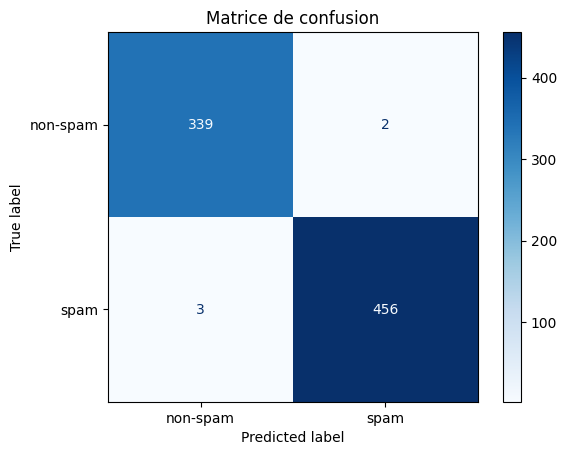

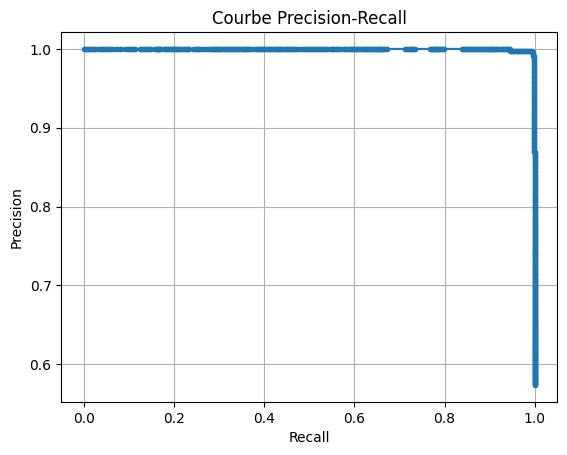

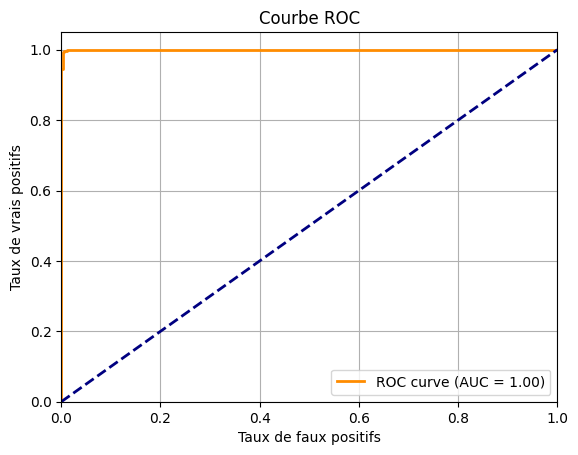

Rapport de classification:

              precision    recall  f1-score   support

    non-spam       0.99      0.99      0.99       341
        spam       1.00      0.99      0.99       459

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800

    Métrique    Valeur
0   Accuracy  0.993750
1  Precision  0.995633
2     Recall  0.993464
3   F1-score  0.994547


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
    auc,
    classification_report,
)
# logits, labels, et scores de probabilités
logits = predictions.predictions
labels = predictions.label_ids
probabilities = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()  # probabilité de la classe positive

# Prédictions binaires en choisissant l'indice max des logits
preds = np.argmax(logits, axis=1)

# --- Matrice de confusion
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-spam', 'spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()

# --- Courbe Precision-Recall
precision, recall, _ = precision_recall_curve(labels, probabilities)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall')
plt.grid(True)
plt.show()

# --- Courbe ROC
fpr, tpr, _ = roc_curve(labels, probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Rapport de classification détaillé
print("Rapport de classification:\n")
print(classification_report(labels, preds, target_names=['non-spam', 'spam']))

# --- Tableaux récapitulatifs des métriques calculées
acc = accuracy_score(labels, preds)
prec = precision_score(labels, preds)
rec = recall_score(labels, preds)
f1 = f1_score(labels, preds)

import pandas as pd

metrics_df = pd.DataFrame({
    "Métrique": ["Accuracy", "Precision", "Recall", "F1-score"],
    "Valeur": [acc, prec, rec, f1]
})

print(metrics_df)

# Conclusion

This notebook demonstrated supervised fine-tuning of a transformer for spam message detection. 
With robust transfer learning and careful dataset design, models like DistilBERT reach high accuracy on binary text classification tasks.
For future work, experiment with different model checkpoints, hyperparameters, or additional data augmentation.


In [18]:
# Chemin où enregistrer le modèle
save_directory = "./saved_model_textonly"

# Sauvegarde du modèle et tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./saved_model_textonly\\tokenizer_config.json',
 './saved_model_textonly\\special_tokens_map.json',
 './saved_model_textonly\\vocab.txt',
 './saved_model_textonly\\added_tokens.json')